# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
USE_GPU = True
TRAIN   = True
RESTORE_PREVIOUS = True

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import time

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Datasets for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
#keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
#                        'left_elbow', 'right_elbow', 'left_wrist',
#                        'right_wrist', 'left_hip', 'right_hip',
#                        'left_knee', 'right_knee', 'left_ankle',
#                        'right_ankle']
keypoints_to_include = None

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=8.68s)
creating index...
index created!
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    #MAX_GT_INSTANCES = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 1000 if USE_GPU else 10
    VALIDATION_STEPS = 50 if USE_GPU else 5
    
    TRAIN_ROIS_PER_IMAGE = 512
    
    RPN_NMS_THRESHOLD = 0.5
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAM

## Train

In [5]:
if TRAIN:
    importlib.reload(modellib)

    # Create model
    print("Creating model...")
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

    # Get path to saved weights
    try:
        if not RESTORE_PREVIOUS: raise Exception("")
        model_path = model.find_last()[1]
        
        # Load trained weights (fill in path to trained weights here)
        assert model_path != "", "Provide path to trained weights"
        print("Loading weights from ", model_path)
        model.load_weights(model_path, by_name=True)
    except:
        # Load weights trained on MS-COCO
        print("Starting from pretrained MS-COCO")
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 17)
input_gt_masks.shape (?, ?, 17)
target_mask.shape (2, ?, ?, ?)
target_mask.dtype <dtype: 'int32'>
fpn_classifier_graph:
x.shape (?, 512, 1, 1, 1024)

Level 0 (?, ?, ?, 256)
Level 1 (?, ?, ?, 256)
Level 2 (?, ?, ?, 256)
Level 3 (?, ?, ?, 256)
build_fpn_mask_graph:
x.shape (1, ?, 14, 14, 256)
x.shape (?, 512, 14, 14, 256)
x.shape (?, 512, 14, 14, 256)
x.shape (?, 512, 14, 14, 256)
x.shape (?, 512, 14, 14, 256)
x.shape (?, 512, 28, 28, 256)
x.shape (?, 512, 28, 28, 17)
x.shape (?, 512, 17, 28, 28)

mrcnn_mask.shape (?, 512, 17, 28, 28)
Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180605T0513/mask_rcnn_coco_keypoints_0031.h5


In [5]:
if TRAIN:
    importlib.reload(modellib)
    
    train_start_time = time.time()
    
    # Training - Stage 1
    print("Training network heads...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers="heads",
                augmentation=None)

Training network heads...

Starting at epoch 17. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180605T0513/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 210804, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210804.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[25.38, 471.68, 25.38, 471.13, 25.38, 470.88, 25.12, 470.75, 25.12, 470.46, 25.21, 470.25, 25.21, 470, 25.21, 469.54, 25.54, 469.33, 25.75, 469.58, 25.75, 470.08, 25.8, 470.21, 26.13, 470.33, 26.13, 470

Exception: INFO: Image with ID 41649 produced erroneus bbox x1 == x2


Epoch 18/40
 883/1000 [=========================>....] - ETA: 1:34 - loss: 8.0322 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.5025 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 7.1993

ERROR:root:Error processing image {'id': 216694, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000216694.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[270.18, 72.76, 269.81, 74.22, 270.36, 74.77, 269.57, 75.56, 269.02, 77.21, 269.2, 78.62, 270.24, 78.8, 271.4, 78.68, 271.95, 78.01, 272.31, 77.09, 272.43, 75.44, 272.5, 74.59, 272.43, 74.1, 272.31, 73.31, 272.01, 72.45, 271.58, 72.27, 270.48, 72.21]], 'num_keypoints': 0, 'area': 16.7839, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 216694, 'bbox': [269.02, 72.21, 3.48, 6.59], 'category_id': 1, 'id': 1692314}, {'segmentation': [[562.61, 82.97, 562.73, 82.01, 562.93, 81.12, 564.2, 80.1, 564.39, 79.01, 564.78, 78.57, 565.67, 78.69, 566.18, 79.08, 566.31, 79.84, 566.31, 81.18, 566.56, 81.44, 567.01, 82.71, 566.88, 83.6]], 'num_

 919/1000 [==========================>...] - ETA: 1:05 - loss: 8.0267 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4987 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 7.1988

ERROR:root:Error processing image {'id': 67018, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000067018.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[412.53, 333.55, 414.4, 333.82, 414.22, 337.12, 417.25, 338.63, 419.12, 341.22, 418.86, 346.03, 417.88, 347.28, 417.07, 348.08, 416.45, 352.36, 416.36, 353.34, 412.97, 353.97, 412.97, 352.54, 412.44, 352.63, 411.64, 353.52, 410.39, 353.34, 409.5, 353.25, 409.5, 351.11, 408.52, 350.4, 408.43, 348.35, 408.78, 347.19, 406.02, 344.87, 405.84, 342.29, 406.11, 340.32, 407.53, 338.45, 409.23, 337.03, 409.94, 336.22, 410.39, 333.91, 412.08, 333.1]], 'num_keypoints': 0, 'area': 179.7029, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 67018, 'bbox': [405.84, 333.1, 13.28, 20.87], 'category_id': 1, 'id': 498856}, {'segmentation': [[503.21

 999/1000 [============================>.] - ETA: 0s - loss: 8.0253 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4963 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 7.1986

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 421060, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000421060.jpg', 'width': 640, 'height': 418, 'annotations': [{'segmentation': [[139.61, 259.01, 155.1, 252.27, 182.71, 209.84, 168.56, 216.58, 167.89, 204.45, 175.97, 197.05, 192.81, 181.56, 217.05, 172.8, 249.38, 163.37, 256.12, 149.9, 268.91, 149.9, 279.69, 157.98, 281.04, 165.39, 274.97, 177.51, 289.12, 194.35, 291.81, 222.64, 283.73, 250.92, 261.5, 272.47, 246.69, 267.09, 252.75, 254.29, 243.32, 261.03, 229.18, 262.37, 215.71, 248.9, 210.99, 261.7, 204.93, 271.8, 192.81, 275.17, 177.32, 263.72, 177.32, 277.19]], 'num_keypoints': 12, 'area': 11417.7497, 

Exception: INFO: Image with ID 1078 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 882s 882ms/step - loss: 8.0258 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4965 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 7.1986 - val_loss: 8.0422 - val_rpn_class_loss: 0.0265 - val_rpn_bbox_loss: 0.5171 - val_mrcnn_bbox_loss: 0.2925 - val_mrcnn_mask_loss: 7.2060
Epoch 19/40
 123/1000 [==>...........................] - ETA: 11:45 - loss: 8.0205 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4835 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 7.1885

ERROR:root:Error processing image {'id': 546211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000546211.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[420.74, 182.67, 419.5, 170.59, 428.79, 156.65, 433.13, 150.45, 434.06, 149.21, 434.06, 143.02, 436.84, 136.51, 440.25, 135.27, 438.7, 128.77, 437.46, 119.48, 439.63, 115.76, 442.42, 112.35, 447.07, 111.42, 453.26, 113.9, 456.36, 115.45, 460.39, 119.17, 463.17, 126.6, 460.7, 134.03, 465.34, 134.96, 465.96, 140.85, 474.02, 142.09, 478.04, 142.71, 487.65, 153.55, 490.12, 158.51, 497.56, 159.74, 497.56, 163.46, 501.58, 164.7, 506.23, 167.18, 508.09, 173.68, 507.16, 176.16, 502.2, 177.4, 499.73, 179.26, 491.05, 178.95, 486.72, 173.68, 482.69, 172.13, 479.9, 168.42, 474.33, 166.56, 475.87, 171.82, 475.56, 175.85, 474.64, 178.02, 474.94, 183.29, 476.49, 190.1, 478.66, 192.27, 479.59, 197.23, 480.21, 202.18, 478.97, 204.66, 480.83, 208.07, 483.31, 209.62, 483.62, 212.4, 482.38,

 143/1000 [===>..........................] - ETA: 11:29 - loss: 8.0178 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4785 - mrcnn_bbox_loss: 0.3178 - mrcnn_mask_loss: 7.1884

ERROR:root:Error processing image {'id': 521004, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000521004.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[458.23, 198.5, 455.83, 195.83, 456.72, 193.96, 457.7, 192.62, 458.32, 191.11, 457.79, 189.42, 456.72, 188.44, 456.19, 187.47, 456.36, 186.4, 455.83, 186.04, 453.96, 186.58, 454.41, 188.35, 454.05, 189.33, 453.61, 190.93, 453.25, 192.71, 453.25, 194.76, 453.16, 196.54, 453.34, 198.05, 453.96, 198.32, 455.39, 198.67, 455.83, 198.67]], 'num_keypoints': 0, 'area': 43.0224, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 521004, 'bbox': [453.16, 186.04, 5.16, 12.63], 'category_id': 1, 'id': 1212558}, {'segmentation': [[454.08, 251, 457.2, 250.94, 460.18, 250.87, 460.12, 239.27, 461.38, 238.41, 461.44, 235.36, 462.57, 234.9, 462.44,

Exception: INFO: Image with ID 62697 produced erroneus bbox x1 == x2


 321/1000 [========>.....................] - ETA: 9:03 - loss: 7.9996 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.4696 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 7.1915

ERROR:root:Error processing image {'id': 336047, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000336047.jpg', 'width': 640, 'height': 434, 'annotations': [{'segmentation': [[31.14, 351.87, 33.35, 357.29, 31.34, 362.31, 26.32, 359.1, 25.31, 356.28, 26.52, 352.87, 26.52, 351.46, 27.92, 350.06, 30.53, 349.86, 31.54, 351.67]], 'num_keypoints': 0, 'area': 64.5222, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 336047, 'bbox': [25.31, 349.86, 8.04, 12.45], 'category_id': 1, 'id': 1206966}, {'segmentation': [[64.3, 356.94, 64.23, 354.57, 63.19, 349.91, 65.19, 349.24, 67.19, 353.61, 66.23, 357.61]], 'num_keypoints': 0, 'area': 20.1588, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 999/1000 [============================>.] - ETA: 0s - loss: 8.0127 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.4832 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 7.1959

ERROR:root:Error processing image {'id': 532530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000532530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[518.85, 410.82, 515.05, 399.4, 514.86, 396.17, 516.38, 392.36, 518.66, 390.65, 518.85, 389.69, 518.66, 388.55, 520.19, 386.27, 521.9, 386.46, 523.42, 388.36, 523.42, 390.08, 523.61, 391.22, 524.76, 397.88, 524.76, 402.45, 523.23, 405.11, 523.42, 407.97, 524.37, 409.87, 524.56, 411.59, 524.56, 412.73, 523.42, 414.44, 521.52, 415.01, 518.09, 415.39, 517.9, 415.39, 516.57, 415.2, 516.57, 414.44, 517.9, 412.73]], 'num_keypoints': 0, 'area': 200.28345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 532530, 'bbox': [514.86, 386.27, 9.9, 29.12], 'category_id': 1, 'id': 1212452}, {'segmentation': [[465.86, 387.96, 464.82, 385.99, 464.7

Exception: INFO: Image with ID 2566 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 839s 839ms/step - loss: 8.0128 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.4834 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 7.1958 - val_loss: 8.0603 - val_rpn_class_loss: 0.0325 - val_rpn_bbox_loss: 0.5290 - val_mrcnn_bbox_loss: 0.3065 - val_mrcnn_mask_loss: 7.1923
Epoch 20/40
 143/1000 [===>..........................] - ETA: 11:25 - loss: 7.9561 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.4404 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 7.1938

ERROR:root:Error processing image {'id': 90793, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000090793.jpg', 'width': 640, 'height': 363, 'annotations': [{'segmentation': [[269.78, 323.2, 269.87, 319.54, 268.18, 318.7, 268.93, 315.04, 270.71, 313.63, 270.43, 312.32, 271.93, 312.6, 272.03, 314.29, 273.34, 316.63, 272.97, 317.48, 271.56, 316.35, 271.65, 318.88, 274, 319.35, 274.19, 323.11, 273.25, 323.86, 273.25, 325.55, 271.75, 325.36, 272.22, 322.45, 272.69, 321.89, 272.31, 320.95, 271.47, 321.14, 270.62, 324.89, 268.65, 323.86, 269.12, 322.83]], 'num_keypoints': 0, 'area': 41.0278, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 90793, 'bbox': [268.18, 312.32, 6.01, 13.23], 'category_id': 1, 'id': 452130}, {'segmentation': [[284.5, 324.75, 284.38, 320.66, 283.79, 318.35, 284.86, 316.45, 285.39, 3

 992/1000 [============================>.] - ETA: 6s - loss: 8.0257 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.4962 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 7.1999

ERROR:root:Error processing image {'id': 566375, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000566375.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[298.39, 396.51, 298.66, 392.33, 298.39, 390.44, 297.44, 389.63, 295.96, 390.58, 295.29, 392.06, 295.55, 394.49, 295.82, 395.57, 296.09, 396.1, 296.23, 397.18, 296.77, 397.86, 297.71, 397.99, 298.12, 396.51]], 'num_keypoints': 0, 'area': 20.70155, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 566375, 'bbox': [295.29, 389.63, 3.37, 8.36], 'category_id': 1, 'id': 258720}, {'segmentation': [[616.51, 329.86, 615.67, 326.98, 617.02, 325.8, 616.68, 322.92, 618.04, 321.73, 620.75, 321.73, 621.43, 324.27, 621.93, 326.14, 622.78, 327.15, 622.95, 328.68, 622.44, 329.69, 622.27, 329.86]], 'num_keypoints': 0, 'area': 43.5818, 'iscrowd': 

 999/1000 [============================>.] - ETA: 0s - loss: 8.0252 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.4953 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 7.1999

ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [154.4, 328.81,

1000/1000 [==============================] - 850s 850ms/step - loss: 8.0252 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.4953 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 7.2000 - val_loss: 8.0101 - val_rpn_class_loss: 0.0335 - val_rpn_bbox_loss: 0.4586 - val_mrcnn_bbox_loss: 0.3122 - val_mrcnn_mask_loss: 7.2057
Epoch 21/40
 250/1000 [======>.......................] - ETA: 9:55 - loss: 8.0558 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.5160 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 7.1986

ERROR:root:Error processing image {'id': 140308, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000140308.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[119.97, 257.96, 117.86, 256.28, 119.12, 253.61, 121.09, 250.81, 122.77, 247.17, 123.33, 245.07, 123.19, 242.69, 122.35, 240.17, 123.05, 236.95, 125.43, 234, 124.31, 230.08, 125.01, 226.86, 126.41, 224.76, 127.25, 223.36, 127.81, 221.4, 128.23, 219.58, 128.79, 218.74, 129.63, 218.18, 131.59, 218.04, 133.41, 219.02, 133.69, 221.4, 133.13, 223.08, 131.31, 224.76, 131.31, 225.04, 132.01, 228.82, 132.01, 230.5, 135.23, 230.36, 136.21, 231.76, 134.81, 232.74, 132.01, 233.3, 130.75, 241.15, 129.91, 246.33, 128.93, 248.29, 128.93, 249.55, 128.65, 251.93, 128.37, 253.89, 128.37, 255.44, 126.55, 254.87, 126.27, 254.87, 125.57, 249.27, 123.89, 251.65]], 'num_keypoints': 0, 'area': 264.3425, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 254/1000 [======>.......................] - ETA: 9:52 - loss: 8.0582 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.5188 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 7.1987

ERROR:root:Error processing image {'id': 520808, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000520808.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[418, 426.15, 418, 420.45, 418.76, 418.55, 419.14, 415.7, 418.76, 413.04, 417.43, 409.24, 414.58, 410.57, 414.77, 417.22, 413.25, 421.4, 414.01, 425.77, 415.72, 426.9]], 'num_keypoints': 0, 'area': 69.54475, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 520808, 'bbox': [413.25, 409.24, 5.89, 17.66], 'category_id': 1, 'id': 1240548}, {'segmentation': [[406.57, 426.06, 405.48, 424.43, 404.76, 423.16, 404.58, 421.89, 404.58, 421.53, 404.94, 419.36, 404.94, 418.27, 404.94, 417.72, 404.76, 417.36, 404.58, 415.19, 404.58, 414.28, 402.76, 415.19, 401.86, 416.82, 400.95, 418.27, 400.77, 419.54, 400.77, 421.35, 401.13, 421.89, 400.95,

 611/1000 [=================>............] - ETA: 5:26 - loss: 8.0542 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.5099 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 7.2031

ERROR:root:Error processing image {'id': 27005, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000027005.jpg', 'width': 640, 'height': 360, 'annotations': [{'segmentation': [[475.38, 162.24, 475.97, 156.56, 473.03, 153.63, 470.49, 154.41, 469.9, 152.06, 470.29, 148.34, 473.42, 145.21, 472.05, 141.68, 474.79, 139.92, 476.75, 140.31, 479.49, 143.64, 482.24, 143.25, 485.56, 145.6, 484, 149.71, 484.98, 152.45, 481.26, 154.41, 480.47, 160.09, 479.3, 164.2, 476.36, 165.57]], 'num_keypoints': 0, 'area': 211.06395, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 27005, 'bbox': [469.9, 139.92, 15.66, 25.65], 'category_id': 1, 'id': 467120}, {'segmentation': [[607.51, 131.58, 605.26, 133.7, 603.38, 136.21, 603.63, 136.96, 605.26, 137.58, 605.26, 139.33, 605.26, 140.33, 604.26, 142.33, 604.26, 143.21, 603.88, 

Exception: INFO: Image with ID 14825 produced erroneus bbox x1 == x2


 770/1000 [======================>.......] - ETA: 3:11 - loss: 8.0527 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.5080 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 7.2035

ERROR:root:Error processing image {'id': 339234, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000339234.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[157.55, 263.37, 160.88, 257.38, 154, 241.61, 170.88, 247.83, 169.77, 256.04, 167.32, 261.82, 165.99, 264.04, 157.55, 265.82], [150, 237.61, 150.67, 233.84, 152, 222.73, 158.44, 213.63, 162.44, 212.96, 159.99, 207.63, 163.77, 204.52, 170.88, 204.52, 171.54, 207.63, 179.09, 207.18, 182.65, 217.62, 183.09, 220.73, 176.65, 222.51, 175.1, 231.84, 173.1, 236.72, 171.32, 245.16]], 'num_keypoints': 14, 'area': 1049.26095, 'iscrowd': 0, 'keypoints': [169, 210, 2, 169, 209, 2, 168, 209, 2, 0, 0, 0, 164, 210, 2, 171, 217, 2, 160, 215, 2, 181, 219, 2, 155, 224, 2, 179, 209, 2, 154, 235, 2, 167, 238, 2, 161, 238, 2, 168, 254, 2, 164, 257, 2, 0, 0, 0, 0, 0, 0], 'image_id': 339234, 'bbox': [150, 204.52, 33.09, 61.3], 'category_id': 1, 'id': 445716}, {'segmentation': [[387.01, 209.96, 

 990/1000 [============================>.] - ETA: 8s - loss: 8.0393 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4982 - mrcnn_bbox_loss: 0.3065 - mrcnn_mask_loss: 7.2020

ERROR:root:Error processing image {'id': 241025, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000241025.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[166.34, 352.5, 165.46, 349.99, 165.46, 348.07, 165.9, 344.23, 166.34, 341.72, 167.38, 339.21, 167.82, 337.88, 169.44, 335.81, 170.92, 334.63, 172.55, 335.07, 173.14, 336.55, 172.25, 338.77, 171.22, 339.21, 171.66, 340.69, 171.07, 345.71, 172.84, 344.82, 172.84, 345.56, 171.95, 348.66, 171.36, 350.43, 170.48, 349.84, 168.12, 349.4, 167.97, 350.43, 166.64, 351.91]], 'num_keypoints': 0, 'area': 82.14365, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 241025, 'bbox': [165.46, 334.63, 7.68, 17.87], 'category_id': 1, 'id': 1268708}, {'segmentation': [[215.58, 341.19, 216.31, 335.58, 216.31, 329.97, 218.27, 327.78, 218.27, 324.86, 2

Exception: INFO: Image with ID 54969 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 8.0392 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4979 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 7.2022

ERROR:root:Error processing image {'id': 308587, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000308587.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[114.29, 372.06, 113.25, 370.78, 114.67, 368.58, 115.83, 368.33, 116.48, 369.74, 117.12, 371.16, 116.09, 372.06, 116.35, 373.87, 119.44, 371.94, 120.34, 371.81, 120.6, 373.22, 118.8, 375.93, 116.22, 376.06, 116.99, 379.67, 120.34, 382.38, 120.22, 383.54, 117.89, 384.57, 113.13, 382.25, 112.35, 377.22, 113.13, 373.48]], 'num_keypoints': 0, 'area': 72.68655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 308587, 'bbox': [112.35, 368.33, 8.25, 16.24], 'category_id': 1, 'id': 485094}, {'segmentation': [[363.48, 342.29, 364.2, 344.07, 365.26, 344.3, 365.38, 353.67, 364.32, 353.32, 364.32, 351.42, 362.18, 348.93, 361.82, 347.63, 363.0

Exception: INFO: Image with ID 1222 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 866s 866ms/step - loss: 8.0396 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4979 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 7.2022 - val_loss: 8.0830 - val_rpn_class_loss: 0.0296 - val_rpn_bbox_loss: 0.5409 - val_mrcnn_bbox_loss: 0.3003 - val_mrcnn_mask_loss: 7.2121
Epoch 22/40
   2/1000 [..............................] - ETA: 13:42 - loss: 7.9631 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.3994 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 7.1996

ERROR:root:Error processing image {'id': 426400, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000426400.jpg', 'width': 445, 'height': 640, 'annotations': [{'segmentation': [[113.65, 476.01, 101.45, 473.57, 105.84, 460.89, 114.62, 457.48, 110.72, 441.87, 110.72, 430.16, 117.06, 425.77, 135.6, 433.58, 150.72, 430.65, 163.4, 436.99, 152.67, 448.21, 147.3, 456.99, 139.99, 470.65, 136.57, 478.45, 130.72, 479.43, 124.87, 479.43], [109.26, 409.68, 110.23, 406.75, 115.11, 403.82, 123.4, 403.82, 126.33, 405.77, 132.18, 400.9, 130.23, 392.12, 130.23, 377.48, 133.65, 370.65, 145.84, 369.19, 154.13, 374.07, 157.55, 390.16, 159.5, 398.94, 164.86, 402.85, 176.57, 411.63, 176.08, 413.58, 159.5, 411.63, 130.23, 410.65]], 'num_keypoints': 17, 'area': 3230.40585, 'iscrowd': 0, 'keypoints': [143, 399, 2, 147, 395, 2, 139, 395, 2, 155, 394, 2, 134, 394, 2, 157, 405, 2, 132, 406, 2, 165, 407, 2, 123, 421, 1, 164, 407, 2, 120, 410, 2, 148, 436, 2, 133, 435, 2, 1

 359/1000 [=========>....................] - ETA: 8:36 - loss: 8.0282 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.4975 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 7.2010

ERROR:root:Error processing image {'id': 479388, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000479388.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[590.19, 209.65, 587.49, 218.8, 585.89, 230.65, 585.41, 236.06, 587.97, 236.41, 584.3, 245.07, 585.2, 251.45, 590.19, 257.48, 593.72, 256.16, 590.61, 250.13, 595.46, 239.11, 597.88, 235.92, 601.83, 243.62, 603.36, 249.02, 603.98, 256.51, 605.58, 257.27, 608.56, 255.26, 607.38, 237.24, 608.56, 232.8, 608, 217.97, 605.58, 211.39, 601.42, 207.71, 602.04, 205.08, 601.63, 203.07, 599.41, 200.64, 596.71, 199.67, 592.75, 200.5, 592.69, 203.42, 592.75, 207.71, 589.15, 209.51]], 'num_keypoints': 0, 'area': 900.22215, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 479388, 'bbox': [584.3, 199.67, 24.26, 57.81], 'category_id': 1, 'id': 52

 362/1000 [=========>....................] - ETA: 8:33 - loss: 8.0247 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4953 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 7.2005

ERROR:root:Error processing image {'id': 216694, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000216694.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[270.18, 72.76, 269.81, 74.22, 270.36, 74.77, 269.57, 75.56, 269.02, 77.21, 269.2, 78.62, 270.24, 78.8, 271.4, 78.68, 271.95, 78.01, 272.31, 77.09, 272.43, 75.44, 272.5, 74.59, 272.43, 74.1, 272.31, 73.31, 272.01, 72.45, 271.58, 72.27, 270.48, 72.21]], 'num_keypoints': 0, 'area': 16.7839, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 216694, 'bbox': [269.02, 72.21, 3.48, 6.59], 'category_id': 1, 'id': 1692314}, {'segmentation': [[562.61, 82.97, 562.73, 82.01, 562.93, 81.12, 564.2, 80.1, 564.39, 79.01, 564.78, 78.57, 565.67, 78.69, 566.18, 79.08, 566.31, 79.84, 566.31, 81.18, 566.56, 81.44, 567.01, 82.71, 566.88, 83.6]], 'num_

 367/1000 [==========>...................] - ETA: 8:29 - loss: 8.0220 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4924 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 7.2007

ERROR:root:Error processing image {'id': 528364, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000528364.jpg', 'width': 640, 'height': 417, 'annotations': [{'segmentation': [[506.93, 222.95, 509.62, 208.96, 509.62, 203.04, 510.16, 193.62, 513.66, 190.66, 517.7, 186.63, 520.39, 186.36, 520.66, 190.93, 522.27, 196.04, 528.73, 204.12, 527.38, 206.81, 521.46, 201.7, 520.12, 207.08, 519.04, 221.61, 515.54, 229.14, 513.93, 228.07, 515.27, 212.19, 513.39, 211.38, 512.31, 217.84, 509.89, 226.99, 508.28, 229.14, 506.66, 228.07]], 'num_keypoints': 0, 'area': 419.38455, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 528364, 'bbox': [506.66, 186.36, 22.07, 42.78], 'category_id': 1, 'id': 212204}, {'segmentation': [[409.53, 197.85, 410.16, 192.02, 410.16, 188.34, 409.53, 185.56, 411.05, 182.26, 412.31, 176.69,

Exception: INFO: Image with ID 2160 produced erroneus bbox x1 == x2


 458/1000 [============>.................] - ETA: 7:16 - loss: 8.0142 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.4871 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 7.2001

ERROR:root:Error processing image {'id': 210849, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210849.jpg', 'width': 640, 'height': 500, 'annotations': [{'segmentation': [[389.72, 334.02, 391.47, 334.02, 392.89, 335.88, 393, 338.07, 393.55, 339.27, 395.3, 340.81, 396.07, 343.21, 396.07, 346.39, 395.41, 349.89, 394.42, 354.92, 395.3, 358.97, 395.19, 362.04, 394.42, 362.25, 393.99, 361.82, 391.36, 361.82, 390.81, 360.61, 389.72, 357.11, 389.61, 355.25, 389.94, 351.31, 389.94, 348.9, 389.94, 346.06, 389.94, 343.21, 388.95, 342.56, 388.08, 339.49, 387.42, 335.88, 388.73, 334.02, 389.06, 333.91]], 'num_keypoints': 0, 'area': 150.42635, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210849, 'bbox': [387.42, 333.91, 8.65, 28.34], 'category_id': 1, 'id': 201659}, {'segmentation': [[465.47, 407.39, 462.

Exception: INFO: Image with ID 41669 produced erroneus bbox x1 == x2


 629/1000 [=================>............] - ETA: 4:58 - loss: 8.0082 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.4767 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 7.2015

ERROR:root:Error processing image {'id': 546211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000546211.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[420.74, 182.67, 419.5, 170.59, 428.79, 156.65, 433.13, 150.45, 434.06, 149.21, 434.06, 143.02, 436.84, 136.51, 440.25, 135.27, 438.7, 128.77, 437.46, 119.48, 439.63, 115.76, 442.42, 112.35, 447.07, 111.42, 453.26, 113.9, 456.36, 115.45, 460.39, 119.17, 463.17, 126.6, 460.7, 134.03, 465.34, 134.96, 465.96, 140.85, 474.02, 142.09, 478.04, 142.71, 487.65, 153.55, 490.12, 158.51, 497.56, 159.74, 497.56, 163.46, 501.58, 164.7, 506.23, 167.18, 508.09, 173.68, 507.16, 176.16, 502.2, 177.4, 499.73, 179.26, 491.05, 178.95, 486.72, 173.68, 482.69, 172.13, 479.9, 168.42, 474.33, 166.56, 475.87, 171.82, 475.56, 175.85, 474.64, 178.02, 474.94, 183.29, 476.49, 190.1, 478.66, 192.27, 479.59, 197.23, 480.21, 202.18, 478.97, 204.66, 480.83, 208.07, 483.31, 209.62, 483.62, 212.4, 482.38,

 999/1000 [============================>.] - ETA: 0s - loss: 8.0257 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4884 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 7.2039

ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [154.4, 328.81,

1000/1000 [==============================] - 845s 845ms/step - loss: 8.0252 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4882 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 7.2038 - val_loss: 7.9971 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 0.4666 - val_mrcnn_bbox_loss: 0.3030 - val_mrcnn_mask_loss: 7.1964
Epoch 23/40
 294/1000 [=======>......................] - ETA: 9:20 - loss: 8.0073 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.4816 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 7.1919

ERROR:root:Error processing image {'id': 436370, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000436370.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[203.99, 483.35, 198.34, 467.66, 198.97, 455.74, 200.22, 436.29, 202.11, 431.9, 192.07, 426.25, 191.44, 422.49, 192.07, 419.98, 189.56, 414.96, 188.3, 405.55, 194.58, 398.64, 192.69, 387.98, 195.2, 376.68, 198.34, 371.04, 200.85, 368.53, 205.87, 362.88, 210.26, 362.88, 214.03, 357.86, 218.42, 357.86, 222.18, 355.98, 223.44, 352.21, 225.95, 342.18, 230.34, 339.04, 227.2, 330.25, 226.58, 319.59, 229.71, 310.8, 241.01, 303.28, 252.93, 303.28, 261.08, 310.18, 265.48, 322.1, 265.48, 335.27, 265.48, 342.8, 271.75, 345.94, 275.51, 350.33, 274.26, 355.98, 279.91, 361, 284.93, 363.51, 292.46, 367.9, 298.1, 371.04, 296.22, 382.96, 300.61, 398.02, 307.51, 404.92, 311.28, 417.47, 310.02, 427.51, 303.12, 436.92, 315.67, 436.29, 325.71, 438.17, 333.24, 443.82, 340.14, 451.97, 345.16, 

 360/1000 [=========>....................] - ETA: 8:26 - loss: 8.0090 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.4834 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 7.1937

ERROR:root:Error processing image {'id': 260050, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000260050.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[284.76, 465.98, 284.76, 388.31, 277.21, 375.37, 277.21, 358.11, 292.31, 344.09, 295.55, 327.91, 297.71, 322.52, 308.49, 327.91, 309.57, 343.01, 312.81, 362.43, 312.81, 395.87, 313.89, 412.04, 319.28, 431.46, 304.18, 468.13]], 'num_keypoints': 13, 'area': 3931.859, 'iscrowd': 0, 'keypoints': [311, 336, 1, 0, 0, 0, 309, 334, 1, 0, 0, 0, 303, 334, 2, 287, 347, 1, 302, 350, 2, 0, 0, 0, 310, 379, 2, 0, 0, 0, 313, 402, 2, 283, 395, 1, 294, 397, 2, 288, 436, 2, 314, 430, 2, 290, 468, 1, 298, 467, 2], 'image_id': 260050, 'bbox': [277.21, 322.52, 42.07, 145.61], 'category_id': 1, 'id': 198640}, {'segmentation': [[490.39, 395.77, 486.82, 377.41, 474.58, 369.75, 480.7, 361.08, 488.35, 355.47, 491.41, 354.96, 493.45, 345.77, 499.58, 344.75, 500.6, 345.77, 506.21, 356.49, 511.82, 36

 496/1000 [=============>................] - ETA: 6:40 - loss: 8.0090 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.4750 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 7.2009

ERROR:root:Error processing image {'id': 370511, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000370511.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[78.81, 368.85, 79.48, 366.83, 80.02, 365.89, 81.78, 367.1, 82.04, 368.58, 83.12, 368.99, 85.28, 370.34, 84.74, 371.68, 84.74, 373.71, 84.07, 375.86, 83.53, 377.48, 83.12, 380.99, 83.8, 383.55, 82.18, 384.36, 81.37, 382.07, 81.24, 382.47, 79.75, 383.01, 78.67, 383.95, 78, 383.01, 79.89, 379.91, 80.16, 378.29, 79.75, 376.4, 78.81, 375.73, 77.46, 376.4, 76.79, 375.19, 77.06, 372.76, 77.46, 371.55]], 'num_keypoints': 0, 'area': 86.91515, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 370511, 'bbox': [76.79, 365.89, 8.49, 18.47], 'category_id': 1, 'id': 422559}, {'segmentation': [[84.03, 384.39, 86, 384.39, 86.27, 378.03, 89.49, 3

 622/1000 [=================>............] - ETA: 5:00 - loss: 8.0010 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.4715 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 7.1979

ERROR:root:Error processing image {'id': 552679, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000552679.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[527.97, 296.03, 526.46, 292.81, 527.78, 290.16, 528.16, 287.69, 530.82, 285.61, 533.66, 286.93, 533.85, 287.88, 536.5, 289.4, 535.56, 292.62, 534.99, 296.79, 535.18, 299.82, 534.42, 301.91, 532.71, 303.99, 530.82, 304.18, 529.49, 302.48, 529.68, 300.58, 529.3, 299.25, 527.97, 297.36, 527.78, 296.98]], 'num_keypoints': 0, 'area': 118.2775, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 552679, 'bbox': [526.46, 285.61, 10.04, 18.57], 'category_id': 1, 'id': 262796}, {'segmentation': [[620.29, 282.03, 620.29, 279.94, 620.29, 277.84, 619.04, 276.17, 619.04, 274.08, 619.04, 273.24, 619.04, 272.4, 619.87, 271.15, 619.87, 269.89, 61

 910/1000 [==========================>...] - ETA: 1:13 - loss: 8.0053 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4769 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 7.1983

ERROR:root:Error processing image {'id': 441433, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000441433.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[457.48, 170.86, 446.06, 169.82, 448.48, 165.32, 450.73, 157.71, 453.15, 150.78, 453.5, 144.21, 456.79, 122.75, 461.11, 117.21, 464.05, 110.29, 467.34, 109.25, 471.67, 112.71, 470.11, 116.35, 467.34, 116, 465.96, 119.98, 461.98, 127.77, 465.26, 127.25, 466.3, 129.84, 466.48, 132.44, 461.8, 130.36, 461.46, 135.9, 462.5, 139.88, 459.9, 143.17, 459.73, 147.84, 460.8, 151.66, 462.64, 161.47, 461.61, 171.89, 460.39, 171.49, 460.18, 156.57, 459.16, 154.93, 454.46, 160.65, 452.62, 165.56, 454.87, 169.03, 457.94, 169.24]], 'num_keypoints': 0, 'area': 458.6233, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 441433, 'bbox': [446.06, 109

1000/1000 [==============================] - 857s 857ms/step - loss: 8.0103 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.4757 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 7.2021 - val_loss: 8.0250 - val_rpn_class_loss: 0.0357 - val_rpn_bbox_loss: 0.4851 - val_mrcnn_bbox_loss: 0.2981 - val_mrcnn_mask_loss: 7.2060
Epoch 24/40
 254/1000 [======>.......................] - ETA: 9:56 - loss: 8.0328 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4845 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 7.2062

ERROR:root:Error processing image {'id': 241025, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000241025.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[166.34, 352.5, 165.46, 349.99, 165.46, 348.07, 165.9, 344.23, 166.34, 341.72, 167.38, 339.21, 167.82, 337.88, 169.44, 335.81, 170.92, 334.63, 172.55, 335.07, 173.14, 336.55, 172.25, 338.77, 171.22, 339.21, 171.66, 340.69, 171.07, 345.71, 172.84, 344.82, 172.84, 345.56, 171.95, 348.66, 171.36, 350.43, 170.48, 349.84, 168.12, 349.4, 167.97, 350.43, 166.64, 351.91]], 'num_keypoints': 0, 'area': 82.14365, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 241025, 'bbox': [165.46, 334.63, 7.68, 17.87], 'category_id': 1, 'id': 1268708}, {'segmentation': [[215.58, 341.19, 216.31, 335.58, 216.31, 329.97, 218.27, 327.78, 218.27, 324.86, 2

Exception: INFO: Image with ID 54969 produced erroneus bbox x1 == x2


 791/1000 [======================>.......] - ETA: 2:45 - loss: 8.0161 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.4766 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 7.1990

ERROR:root:Error processing image {'id': 135486, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000135486.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[446.86, 305.18, 442.78, 307.73, 448.39, 310.79, 463.19, 305.18, 460.64, 271, 461.66, 263.85, 464.72, 299.06, 466.25, 303.14, 462.68, 308.75, 476.46, 308.75, 476.97, 301.1, 479.01, 272.53, 476.46, 263.34, 481.05, 240.89, 480.03, 231.2, 480.54, 208.75, 480.03, 201.6, 484.62, 193.44, 489.21, 183.24, 488.19, 177.11, 482.07, 159.76, 484.62, 154.66, 478.5, 147.01, 477.99, 154.66, 474.92, 151.09, 475.43, 156.19, 481.56, 178.64, 474.92, 180.68, 473.9, 180.17, 477.99, 172.52, 477.48, 165.38, 472.88, 162.32, 467.78, 161.29, 463.19, 166.4, 461.15, 173.03, 461.15, 179.66, 460.13, 182.72, 449.41, 178.13, 444.31, 177.11, 439.72, 172.01, 435.13, 162.32, 435.13, 152.11, 436.15, 148.54, 428.49, 147.01, 425.43, 149.56, 425.94, 157.21, 430.02, 161.81, 430.53, 178.64, 447.37, 191.4, 446.86

 970/1000 [============================>.] - ETA: 23s - loss: 8.0085 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.4688 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 7.1985

ERROR:root:Error processing image {'id': 256896, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000256896.jpg', 'width': 500, 'height': 333, 'annotations': [{'segmentation': [[168.93, 281.27, 168.2, 277.26, 168.2, 276.54, 165.29, 274.9, 165.47, 272.53, 163.65, 269.99, 165.65, 267.8, 168.02, 266.53, 168.74, 266.35, 168.74, 264.71, 169.29, 263.62, 170.56, 263.8, 170.93, 265.62, 171.11, 266.35, 173.29, 268.89, 173.48, 275.08, 173.11, 283.09, 170.2, 282.72]], 'num_keypoints': 0, 'area': 111.36275, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 256896, 'bbox': [163.65, 263.62, 9.83, 19.47], 'category_id': 1, 'id': 225831}, {'segmentation': [[154.18, 276.63, 154.81, 282.59, 156.02, 280.74, 156.16, 276.49, 158, 273.09, 159.56, 282.73, 159.7, 282.44, 161.12, 282.02, 156.59, 262.74, 152.19, 272.38, 153.61, 

 999/1000 [============================>.] - ETA: 0s - loss: 8.0050 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4662 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 7.1977

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

Exception: INFO: Image with ID 1222 produced erroneus bbox x1 == x2
ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1000/1000 [==============================] - 831s 831ms/step - loss: 8.0052 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4662 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 7.1976 - val_loss: 8.0271 - val_rpn_class_loss: 0.0373 - val_rpn_bbox_loss: 0.4669 - val_mrcnn_bbox_loss: 0.3039 - val_mrcnn_mask_loss: 7.2190
Epoch 25/40
 421/1000 [===========>..................] - ETA: 7:33 - loss: 7.9982 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.4584 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 7.2059

ERROR:root:Error processing image {'id': 210849, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000210849.jpg', 'width': 640, 'height': 500, 'annotations': [{'segmentation': [[389.72, 334.02, 391.47, 334.02, 392.89, 335.88, 393, 338.07, 393.55, 339.27, 395.3, 340.81, 396.07, 343.21, 396.07, 346.39, 395.41, 349.89, 394.42, 354.92, 395.3, 358.97, 395.19, 362.04, 394.42, 362.25, 393.99, 361.82, 391.36, 361.82, 390.81, 360.61, 389.72, 357.11, 389.61, 355.25, 389.94, 351.31, 389.94, 348.9, 389.94, 346.06, 389.94, 343.21, 388.95, 342.56, 388.08, 339.49, 387.42, 335.88, 388.73, 334.02, 389.06, 333.91]], 'num_keypoints': 0, 'area': 150.42635, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 210849, 'bbox': [387.42, 333.91, 8.65, 28.34], 'category_id': 1, 'id': 201659}, {'segmentation': [[465.47, 407.39, 462.

Exception: INFO: Image with ID 41669 produced erroneus bbox x1 == x2


 433/1000 [===========>..................] - ETA: 7:24 - loss: 7.9970 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.4594 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 7.2059

ERROR:root:Error processing image {'id': 574623, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000574623.jpg', 'width': 368, 'height': 640, 'annotations': [{'segmentation': [[19.58, 579.92, 19.64, 575.89, 20.52, 572.16, 20.17, 570.76, 19.17, 570.35, 19.17, 569.42, 18.59, 568.83, 17.83, 568.89, 17.31, 569.24, 17.31, 570.41, 17.54, 571.23, 17.25, 571.93, 16.78, 573.33, 16.78, 575.19, 16.9, 576.19, 17.6, 576.77, 17.48, 579.34, 16.61, 579.86, 17.95, 580.45]], 'num_keypoints': 0, 'area': 29.41415, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 574623, 'bbox': [16.61, 568.83, 3.91, 11.62], 'category_id': 1, 'id': 461729}, {'segmentation': [[120.6, 544.29, 106.85, 577.12, 85.78, 575.79, 81.78, 575.57, 81.34, 570.91, 82.89, 569.36, 83.34, 568.69, 85.33, 565.81, 87.11, 565.36, 87.77, 567.36, 88.22, 567.58,

 588/1000 [================>.............] - ETA: 5:24 - loss: 8.0025 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.4681 - mrcnn_bbox_loss: 0.3008 - mrcnn_mask_loss: 7.2027

ERROR:root:Error processing image {'id': 350111, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000350111.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[213.91, 351.87, 213.91, 351.87, 214.8, 342.35, 212.04, 339.41, 212.66, 338.35, 214.17, 337.01, 215.06, 341.1, 215.86, 338.35, 217.2, 340.3, 217.82, 343.77, 218.53, 349.11, 216.49, 351.33, 216.49, 352.76, 213.82, 352.31]], 'num_keypoints': 0, 'area': 49.6591, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 350111, 'bbox': [212.04, 337.01, 6.49, 15.75], 'category_id': 1, 'id': 559381}, {'segmentation': [[507.68, 321.53, 506.5, 323.89, 506.97, 326.49, 502.96, 325.54, 504.61, 322.95, 504.14, 319.64, 505.79, 319.4, 506.73, 318.46, 508.15, 318.93, 508.62, 321.06]], 'num_keypoints': 0, 'area': 23.3536, 'iscrowd': 0, 'keypoints': [0, 

 866/1000 [========================>.....] - ETA: 1:45 - loss: 8.0064 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.4727 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 7.2019

ERROR:root:Error processing image {'id': 339234, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000339234.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[157.55, 263.37, 160.88, 257.38, 154, 241.61, 170.88, 247.83, 169.77, 256.04, 167.32, 261.82, 165.99, 264.04, 157.55, 265.82], [150, 237.61, 150.67, 233.84, 152, 222.73, 158.44, 213.63, 162.44, 212.96, 159.99, 207.63, 163.77, 204.52, 170.88, 204.52, 171.54, 207.63, 179.09, 207.18, 182.65, 217.62, 183.09, 220.73, 176.65, 222.51, 175.1, 231.84, 173.1, 236.72, 171.32, 245.16]], 'num_keypoints': 14, 'area': 1049.26095, 'iscrowd': 0, 'keypoints': [169, 210, 2, 169, 209, 2, 168, 209, 2, 0, 0, 0, 164, 210, 2, 171, 217, 2, 160, 215, 2, 181, 219, 2, 155, 224, 2, 179, 209, 2, 154, 235, 2, 167, 238, 2, 161, 238, 2, 168, 254, 2, 164, 257, 2, 0, 0, 0, 0, 0, 0], 'image_id': 339234, 'bbox': [150, 204.52, 33.09, 61.3], 'category_id': 1, 'id': 445716}, {'segmentation': [[387.01, 209.96, 

1000/1000 [==============================] - 828s 828ms/step - loss: 8.0174 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.4799 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 7.2042 - val_loss: 8.0599 - val_rpn_class_loss: 0.0325 - val_rpn_bbox_loss: 0.5189 - val_mrcnn_bbox_loss: 0.3204 - val_mrcnn_mask_loss: 7.1882
Epoch 26/40
  68/1000 [=>............................] - ETA: 12:17 - loss: 8.0777 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.5254 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 7.2131

ERROR:root:Error processing image {'id': 259249, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000259249.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[218.93, 166.3, 218.11, 170.67, 223.3, 187.58, 224.66, 198.22, 228.48, 198.76, 228.21, 187.31, 233.66, 190.58, 234.76, 197.4, 238.85, 193.85, 237.48, 187.58, 232.3, 175.85, 232.57, 165.48, 232.3, 164.66, 227.94, 163.3, 228.48, 156.75, 224.66, 155.66, 220.57, 160.03, 221.66, 163.3]], 'num_keypoints': 0, 'area': 457.6327, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 259249, 'bbox': [218.11, 155.66, 20.74, 43.1], 'category_id': 1, 'id': 213136}, {'segmentation': [[51.79, 173.99, 52.37, 172.45, 51.79, 170.42, 49.47, 170.42, 49.47, 172.35, 50.63, 173.51, 51.59, 174.19]], 'num_keypoints': 0, 'area': 7.9737, 'iscrowd': 0, 'keypoint

  74/1000 [=>............................] - ETA: 12:13 - loss: 8.0886 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.5334 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 7.2139

ERROR:root:Error processing image {'id': 154346, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000154346.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[382.28, 291.14, 383.08, 289.88, 383.65, 289.53, 384.11, 288.96, 384.46, 287.92, 385.83, 286.89, 387.44, 287.35, 387.9, 289.19, 387.56, 290.33, 389.51, 293.09, 388.36, 295.5, 388.02, 297.57, 387.67, 302.27, 386.87, 305.03, 385.15, 305.14, 382.85, 305.26, 382.39, 298.14, 382.97, 295.96, 382.28, 293.66, 382.16, 293.32, 381.82, 291.83]], 'num_keypoints': 0, 'area': 93.90755, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 154346, 'bbox': [381.82, 286.89, 7.69, 18.37], 'category_id': 1, 'id': 213040}, {'segmentation': [[406.85, 300.92, 407.01, 305.42, 405.52, 305.59, 406.01, 301.76, 404.18, 301.76, 404.02, 299.92, 404.18, 298.59, 4

Exception: INFO: Image with ID 12734 produced erroneus bbox x1 == x2


 284/1000 [=======>......................] - ETA: 9:29 - loss: 8.0636 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.5220 - mrcnn_bbox_loss: 0.3050 - mrcnn_mask_loss: 7.2039

ERROR:root:Error processing image {'id': 263760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000263760.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[499.46, 146.49, 515.68, 163.78, 517.84, 187.57, 524.32, 234.05, 534.05, 262.16, 541.62, 275.14, 539.46, 290.27, 530.81, 303.24, 532.97, 316.22, 534.05, 324.86, 523.24, 360.54, 508.11, 370.27, 490.81, 377.84, 472.43, 382.16, 450.81, 381.08, 425.95, 368.11, 402.16, 354.05, 387.03, 344.32, 362.16, 320.54, 347.03, 306.49, 326.49, 322.7, 315.68, 335.68, 301.62, 349.73, 294.05, 360.54, 281.08, 370.27, 265.95, 375.68, 254.05, 374.59, 243.24, 368.11, 236.76, 368.11, 228.11, 370.27, 214.05, 373.51, 201.08, 368.11, 191.35, 360.54, 164.32, 336.76, 160, 316.22, 160, 301.08, 174.05, 295.68, 194.59, 300, 211.89, 312.97, 229.19, 318.38, 233.51, 311.89, 229.19, 298.92, 225.95, 280.54, 227.03, 267.57, 235.68, 255.68, 245.41, 253.51, 260.54, 262.16, 273.51, 267.57, 286.49, 264.32, 278.92

Exception: INFO: Image with ID 890 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 8.0255 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.4941 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 7.1994

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

Exception: INFO: Image with ID 1222 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 838s 838ms/step - loss: 8.0248 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.4938 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 7.1992 - val_loss: 8.0608 - val_rpn_class_loss: 0.0322 - val_rpn_bbox_loss: 0.4825 - val_mrcnn_bbox_loss: 0.3228 - val_mrcnn_mask_loss: 7.2233
Epoch 27/40
 111/1000 [==>...........................] - ETA: 11:57 - loss: 7.9697 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.4695 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 7.1870

ERROR:root:Error processing image {'id': 546211, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000546211.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[420.74, 182.67, 419.5, 170.59, 428.79, 156.65, 433.13, 150.45, 434.06, 149.21, 434.06, 143.02, 436.84, 136.51, 440.25, 135.27, 438.7, 128.77, 437.46, 119.48, 439.63, 115.76, 442.42, 112.35, 447.07, 111.42, 453.26, 113.9, 456.36, 115.45, 460.39, 119.17, 463.17, 126.6, 460.7, 134.03, 465.34, 134.96, 465.96, 140.85, 474.02, 142.09, 478.04, 142.71, 487.65, 153.55, 490.12, 158.51, 497.56, 159.74, 497.56, 163.46, 501.58, 164.7, 506.23, 167.18, 508.09, 173.68, 507.16, 176.16, 502.2, 177.4, 499.73, 179.26, 491.05, 178.95, 486.72, 173.68, 482.69, 172.13, 479.9, 168.42, 474.33, 166.56, 475.87, 171.82, 475.56, 175.85, 474.64, 178.02, 474.94, 183.29, 476.49, 190.1, 478.66, 192.27, 479.59, 197.23, 480.21, 202.18, 478.97, 204.66, 480.83, 208.07, 483.31, 209.62, 483.62, 212.4, 482.38,

 288/1000 [=======>......................] - ETA: 9:34 - loss: 8.0185 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4862 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 7.1968

ERROR:root:Error processing image {'id': 430529, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000430529.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[290.61, 206.9, 290.27, 201.19, 292.29, 197.99, 294.47, 193.46, 298.17, 195.14, 300.69, 197.66, 300.35, 203.88, 301.03, 208.75, 300.35, 213.79, 298.51, 220.85, 298.84, 230.43, 296.49, 233.96, 288.42, 230.6, 291.95, 219, 291.28, 215.64]], 'num_keypoints': 0, 'area': 336.49295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 430529, 'bbox': [288.42, 193.46, 12.61, 40.5], 'category_id': 1, 'id': 528861}, {'segmentation': [[434.16, 192.53, 434.01, 195.22, 433.21, 195.14, 432.98, 192.92, 432.66, 191.42, 433.61, 190.07, 434.16, 192.37]], 'num_keypoints': 0, 'area': 4.9678, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 698/1000 [===================>..........] - ETA: 4:03 - loss: 8.0220 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.4882 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 7.2033

ERROR:root:Error processing image {'id': 364959, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000364959.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[101, 333.15, 101.43, 330.17, 100.79, 325.27, 100.79, 323.77, 99.72, 323.77, 101, 317.81, 97.38, 315.04, 99.51, 311.84, 102.07, 309.71, 102.07, 307.8, 104.2, 306.09, 105.69, 305.88, 108.25, 308.22, 106.76, 309.07, 106.76, 310.57, 108.25, 311.63, 107.82, 314.4, 107.61, 316.11, 107.61, 318.02, 109.31, 321.64, 109.74, 324.84, 109.74, 328.89, 109.31, 331.23, 109.31, 334, 108.46, 334.43, 106.97, 333.57, 107.18, 331.87, 106.97, 329.31, 106.76, 326.12, 105.69, 324.2, 104.84, 325.48, 104.41, 328.04, 104.41, 330.81, 104.41, 332.94, 103.77, 334.64, 101, 334.43]], 'num_keypoints': 0, 'area': 200.7473, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '

Exception: INFO: Image with ID 51819 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 8.0124 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.4800 - mrcnn_bbox_loss: 0.2984 - mrcnn_mask_loss: 7.2031

ERROR:root:Error processing image {'id': 143068, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000143068.jpg', 'width': 640, 'height': 213, 'annotations': [{'segmentation': [[535.89, 209.44, 542.49, 178.81, 542.49, 164.67, 537.3, 165.14, 533.06, 155.71, 536.36, 151.94, 541.54, 148.64, 543.9, 148.17, 544.84, 140.16, 546.26, 130.73, 551.91, 128.84, 561.34, 133.09, 565.11, 140.63, 564.64, 146.28, 569.82, 150.05, 573.12, 162.31, 581.61, 176.92, 569.82, 175.51, 574.54, 193.42, 573.12, 208.03, 566.52, 209.44, 559.45, 208.5, 554.27, 203.31, 545.78, 211.8]], 'num_keypoints': 7, 'area': 2409.64295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 138, 2, 542, 151, 2, 569, 151, 2, 540, 167, 1, 573, 166, 2, 0, 0, 0, 0, 0, 0, 543, 195, 2, 568, 195, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 143068, 'bbox': [533.06, 128.84, 48.55, 82.96], 'category_id': 1, 'id': 430155}, {'segmentation': [[527.01, 132.97, 527.01, 132.97, 529.01

Exception: INFO: Image with ID 1222 produced erroneus bbox x1 == x2
ERROR:root:Error processing image {'id': 532530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000532530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[518.85, 410.82, 515.05, 399.4, 514.86, 396.17, 516.38, 392.36, 518.66, 390.65, 518.85, 389.69, 518.66, 388.55, 520.19, 386.27, 521.9, 386.46, 523.42, 388.36, 523.42, 390.08, 523.61, 391.22, 524.76, 397.88, 524.76, 402.45, 523.23, 405.11, 523.42, 407.97, 524.37, 409.87, 524.56, 411.59, 524.56, 412.73, 523.42, 414.44, 521.52, 415.01, 518.09, 415.39, 517.9, 415.39, 516.57, 415.2, 516.57, 414.44, 517.9, 412.73]], 'num_keypoints': 0, 'area': 200.28345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 532530, 'bbox': [514.86, 386.27, 9.9, 29.12], 'category_id': 1, 'id'

1000/1000 [==============================] - 876s 876ms/step - loss: 8.0125 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.4799 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 7.2031 - val_loss: 8.0135 - val_rpn_class_loss: 0.0316 - val_rpn_bbox_loss: 0.4886 - val_mrcnn_bbox_loss: 0.2953 - val_mrcnn_mask_loss: 7.1980
Epoch 28/40
 211/1000 [=====>........................] - ETA: 12:12 - loss: 7.9903 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4659 - mrcnn_bbox_loss: 0.2860 - mrcnn_mask_loss: 7.2070

ERROR:root:Error processing image {'id': 103931, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000103931.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[422.04, 330.67, 433.72, 334.17, 436.64, 301.47, 441.31, 335.34, 449.49, 337.68, 452.41, 325.41, 455.32, 311.4, 452.41, 283.96, 458.83, 268.19, 452.99, 254.76, 450.65, 233.16, 443.65, 227.9, 429.63, 231.41, 430.22, 248.92, 416.2, 258.85, 423.21, 279.29]], 'num_keypoints': 12, 'area': 3031.35605, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 244, 1, 448, 243, 2, 427, 258, 2, 447, 257, 2, 420, 268, 2, 456, 269, 2, 0, 0, 0, 0, 0, 0, 430, 288, 2, 443, 288, 2, 429, 310, 2, 444, 311, 2, 427, 327, 2, 445, 329, 2], 'image_id': 103931, 'bbox': [416.2, 227.9, 42.63, 109.78], 'category_id': 1, 'id': 1204077}, {'segmentation': [[277.69, 296.43, 298.46, 295.44, 300.93, 291.49, 296.98, 289.02, 291.54, 287.53, 290.55, 276.16, 291.04, 261.33, 298.95, 224.74, 296.98, 220.29

Exception: INFO: Image with ID 52348 produced erroneus bbox x1 == x2


 633/1000 [=================>............] - ETA: 5:24 - loss: 8.0009 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.4791 - mrcnn_bbox_loss: 0.2900 - mrcnn_mask_loss: 7.2009

ERROR:root:Error processing image {'id': 350111, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000350111.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[213.91, 351.87, 213.91, 351.87, 214.8, 342.35, 212.04, 339.41, 212.66, 338.35, 214.17, 337.01, 215.06, 341.1, 215.86, 338.35, 217.2, 340.3, 217.82, 343.77, 218.53, 349.11, 216.49, 351.33, 216.49, 352.76, 213.82, 352.31]], 'num_keypoints': 0, 'area': 49.6591, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 350111, 'bbox': [212.04, 337.01, 6.49, 15.75], 'category_id': 1, 'id': 559381}, {'segmentation': [[507.68, 321.53, 506.5, 323.89, 506.97, 326.49, 502.96, 325.54, 504.61, 322.95, 504.14, 319.64, 505.79, 319.4, 506.73, 318.46, 508.15, 318.93, 508.62, 321.06]], 'num_keypoints': 0, 'area': 23.3536, 'iscrowd': 0, 'keypoints': [0, 

 765/1000 [=====================>........] - ETA: 3:24 - loss: 7.9918 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.4735 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 7.1988

ERROR:root:Error processing image {'id': 516633, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000516633.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[201.01, 97.2, 202.62, 97.2, 202.62, 99.01, 201.62, 99.48, 203.02, 101.42, 202.22, 104.77, 199.67, 104.91, 199.81, 99.01]], 'num_keypoints': 0, 'area': 19.9406, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 516633, 'bbox': [199.67, 97.2, 3.35, 7.71], 'category_id': 1, 'id': 1242700}, {'segmentation': [[466, 225.58, 466.12, 244.77, 464.68, 244.89, 462.28, 244.41, 459.88, 244.17, 458.08, 244.05, 456.88, 243.93, 456.76, 243.33, 458.32, 241.65, 455.93, 240.45, 456.64, 238.42, 457.24, 233.86, 458.92, 230.02, 460.24, 228.58, 460.6, 226.06, 461.44, 224.62, 463.48, 224.14, 464.8, 224.14, 465.76, 224.86]], 'num_keypoints': 0, 'area': 

 895/1000 [=========================>....] - ETA: 1:30 - loss: 7.9961 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.4802 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 7.1979

ERROR:root:Error processing image {'id': 568101, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000568101.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[303, 372.15, 306.24, 372.29, 306.24, 366.99, 306.83, 368.02, 308.89, 372.74, 310.95, 371.56, 309.48, 365.67, 308.3, 359.33, 307.27, 355.65, 304.91, 355.5, 304.91, 357.86, 303.88, 360.07]], 'num_keypoints': 0, 'area': 83.53605, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 568101, 'bbox': [303, 355.5, 7.95, 17.24], 'category_id': 1, 'id': 430527}, {'segmentation': [[306.1, 339.86, 308.17, 339.67, 308.46, 332.41, 307.96, 331.74, 307.72, 331.66, 307.45, 330.84, 306.68, 330.71, 305.96, 331.05, 305.46, 331.93, 305.46, 332.83, 305.08, 332.78, 304.98, 331.5, 304.63, 330.95, 303.94, 331.05, 303.68, 331.32, 303.46, 332.46, 303.41, 33

1000/1000 [==============================] - 893s 893ms/step - loss: 7.9981 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.4844 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 7.1957 - val_loss: 8.1308 - val_rpn_class_loss: 0.0425 - val_rpn_bbox_loss: 0.5770 - val_mrcnn_bbox_loss: 0.3313 - val_mrcnn_mask_loss: 7.1799
Epoch 29/40
1000/1000 [==============================] - 834s 834ms/step - loss: 8.0122 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.4878 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 7.1940 - val_loss: 8.0362 - val_rpn_class_loss: 0.0268 - val_rpn_bbox_loss: 0.5045 - val_mrcnn_bbox_loss: 0.2964 - val_mrcnn_mask_loss: 7.2085
Epoch 30/40
 178/1000 [====>.........................] - ETA: 12:36 - loss: 8.0406 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.4987 - mrcnn_bbox_loss: 0.3128 - mrcnn_mask_loss: 7.1976

ERROR:root:Error processing image {'id': 336047, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000336047.jpg', 'width': 640, 'height': 434, 'annotations': [{'segmentation': [[31.14, 351.87, 33.35, 357.29, 31.34, 362.31, 26.32, 359.1, 25.31, 356.28, 26.52, 352.87, 26.52, 351.46, 27.92, 350.06, 30.53, 349.86, 31.54, 351.67]], 'num_keypoints': 0, 'area': 64.5222, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 336047, 'bbox': [25.31, 349.86, 8.04, 12.45], 'category_id': 1, 'id': 1206966}, {'segmentation': [[64.3, 356.94, 64.23, 354.57, 63.19, 349.91, 65.19, 349.24, 67.19, 353.61, 66.23, 357.61]], 'num_keypoints': 0, 'area': 20.1588, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 381/1000 [==========>...................] - ETA: 10:12 - loss: 8.0632 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.5226 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 7.1978

ERROR:root:Error processing image {'id': 39137, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000039137.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[181.21, 133.75, 197.39, 127.28, 228.67, 129.44, 245.93, 131.6, 254.56, 145.62, 256.72, 170.43, 261.03, 185.53, 271.82, 195.24, 291.24, 209.26, 313.89, 225.44, 324.67, 228.67, 357.03, 225.44, 369.98, 220.04, 387.24, 223.28, 408.81, 232.99, 420.67, 239.46, 449.8, 239.46, 456.27, 239.46, 473.53, 244.85, 489.71, 257.8, 499.42, 262.11, 502.65, 273.98, 494.02, 278.29, 461.66, 280.45, 413.12, 282.61, 378.61, 282.61, 350.56, 279.37, 335.46, 280.45, 344.09, 295.55, 327.91, 305.26, 280.45, 300.94, 232.99, 299.87, 212.49, 304.18, 192, 300.94, 185.53, 297.71, 195.24, 289.08, 206.02, 284.76, 201.71, 282.61, 151.01, 291.24, 119.73, 295.55, 113.26, 286.92, 133.75, 284.76, 158.56, 277.21, 186.61, 272.9, 197.39, 267.51, 207.1, 262.11, 215.73, 248.09, 217.89, 228.67, 217.89, 221.12, 209.2

 833/1000 [=======================>......] - ETA: 2:37 - loss: 8.0141 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.4841 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 7.1983

ERROR:root:Error processing image {'id': 134760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000134760.jpg', 'width': 640, 'height': 484, 'annotations': [{'segmentation': [[330.72, 305.23, 331.94, 306.96, 333.77, 307.06, 333.77, 311.64, 333.26, 312.66, 334.59, 316.53, 332.96, 316.94, 331.43, 316.94, 331.22, 316.02, 330.21, 312.87, 329.9, 312.05, 328.68, 308.18, 330.21, 307.26, 329.49, 305.84]], 'num_keypoints': 0, 'area': 40.0667, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 134760, 'bbox': [328.68, 305.23, 5.91, 11.71], 'category_id': 1, 'id': 452904}, {'segmentation': [[511.12, 345.88, 515.38, 337.37, 518.93, 332.4, 537.37, 348.71, 542.33, 346.94, 531.69, 336.66, 526.73, 333.11, 524.6, 329.92, 524.25, 324.95, 524.25, 318.92, 529.21, 323.18, 530.27, 331.69, 531.69, 334.17, 533.82, 330.27, 533

Exception: INFO: Image with ID 1966 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 8.0127 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4813 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 7.1975

ERROR:root:Error processing image {'id': 308587, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000308587.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[114.29, 372.06, 113.25, 370.78, 114.67, 368.58, 115.83, 368.33, 116.48, 369.74, 117.12, 371.16, 116.09, 372.06, 116.35, 373.87, 119.44, 371.94, 120.34, 371.81, 120.6, 373.22, 118.8, 375.93, 116.22, 376.06, 116.99, 379.67, 120.34, 382.38, 120.22, 383.54, 117.89, 384.57, 113.13, 382.25, 112.35, 377.22, 113.13, 373.48]], 'num_keypoints': 0, 'area': 72.68655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 308587, 'bbox': [112.35, 368.33, 8.25, 16.24], 'category_id': 1, 'id': 485094}, {'segmentation': [[363.48, 342.29, 364.2, 344.07, 365.26, 344.3, 365.38, 353.67, 364.32, 353.32, 364.32, 351.42, 362.18, 348.93, 361.82, 347.63, 363.0

1000/1000 [==============================] - 959s 959ms/step - loss: 8.0128 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4813 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 7.1975 - val_loss: 8.1338 - val_rpn_class_loss: 0.0337 - val_rpn_bbox_loss: 0.5830 - val_mrcnn_bbox_loss: 0.3089 - val_mrcnn_mask_loss: 7.2082
Epoch 31/40
  37/1000 [>.............................] - ETA: 12:48 - loss: 8.0123 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4955 - mrcnn_bbox_loss: 0.2950 - mrcnn_mask_loss: 7.1895

ERROR:root:Error processing image {'id': 156282, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000156282.jpg', 'width': 375, 'height': 500, 'annotations': [{'segmentation': [[219.89, 492.92, 217.98, 466.14, 214.98, 451.66, 216.34, 442.1, 214.43, 433.35, 216.34, 417.51, 215.8, 402.48, 219.89, 391.82, 227.82, 382.81, 233.55, 375.98, 228.64, 358.77, 227.82, 344.56, 229.46, 332.54, 230.55, 325.16, 236.56, 319.97, 242.84, 300.3, 252.68, 292.65, 254.87, 288.55, 258.14, 286.91, 261.97, 289.37, 261.97, 296.2, 258.69, 306.31, 253.23, 313.14, 251.04, 321.88, 247.22, 333.08, 258.14, 337.18, 259.51, 345.92, 263.88, 335.54, 265.79, 324.07, 267.71, 314.23, 268.8, 308.77, 272.08, 302.76, 277, 299.48, 283.01, 302.21, 283.28, 313.14, 281.91, 326.25, 277.27, 338.82, 272.08, 357.13, 275.08, 374.89, 273.17, 381.44, 264.7, 399.2, 266.07, 422.7, 263.33, 429.26, 262.24, 434.17, 262.24, 459.04, 256.5, 478.71, 255.14, 488, 253.23, 492.92, 250.77, 500, 222.9, 500]], 

 500/1000 [==============>...............] - ETA: 6:40 - loss: 8.0022 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.4656 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 7.2058

ERROR:root:Error processing image {'id': 528364, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000528364.jpg', 'width': 640, 'height': 417, 'annotations': [{'segmentation': [[506.93, 222.95, 509.62, 208.96, 509.62, 203.04, 510.16, 193.62, 513.66, 190.66, 517.7, 186.63, 520.39, 186.36, 520.66, 190.93, 522.27, 196.04, 528.73, 204.12, 527.38, 206.81, 521.46, 201.7, 520.12, 207.08, 519.04, 221.61, 515.54, 229.14, 513.93, 228.07, 515.27, 212.19, 513.39, 211.38, 512.31, 217.84, 509.89, 226.99, 508.28, 229.14, 506.66, 228.07]], 'num_keypoints': 0, 'area': 419.38455, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 528364, 'bbox': [506.66, 186.36, 22.07, 42.78], 'category_id': 1, 'id': 212204}, {'segmentation': [[409.53, 197.85, 410.16, 192.02, 410.16, 188.34, 409.53, 185.56, 411.05, 182.26, 412.31, 176.69,

Exception: INFO: Image with ID 2160 produced erroneus bbox x1 == x2


 834/1000 [========================>.....] - ETA: 2:12 - loss: 8.0053 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.4736 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 7.2040

ERROR:root:Error processing image {'id': 272153, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000272153.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[209.87, 188.66, 208.03, 182.93, 208.23, 181.7, 209.87, 179.65, 209.87, 177.81, 211.3, 176.37, 209.87, 174.53, 209.66, 174.53, 210.07, 171.46, 210.07, 168.39, 206.8, 163.68, 205.16, 160.6, 201.68, 159.17, 195.94, 159.17, 191.64, 160.6, 188.77, 162.45, 186.11, 167.16, 185.7, 169, 185.7, 172.07, 185.09, 174.12, 184.06, 175.15, 183.86, 175.35, 184.06, 177.81, 184.27, 179.65, 182.83, 181.09, 180.58, 185.8, 179.15, 188.66, 173, 189.48, 163.58, 195.63, 160.1, 204.44, 156.61, 212.01, 150.47, 227.99, 147.6, 236.39, 147.19, 240.9, 144.12, 247.65, 143.91, 253.18, 143.1, 260.76, 142.89, 264.25, 142.89, 267.93, 142.69, 270.39, 142.28, 271.41, 142.28, 276.13, 141.87, 278.58, 142.48, 280.02, 144.73, 283.09, 146.17, 285.14, 146.99, 283.29, 148.01, 282.27, 148.83, 278.99, 152.11, 271.21

 948/1000 [===========================>..] - ETA: 41s - loss: 8.0058 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.4754 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 7.2020

ERROR:root:Error processing image {'id': 477398, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000477398.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[475.83, 368.88, 477.38, 370.24, 478.8, 370.68, 478.49, 375.99, 477.81, 380.75, 477.75, 382.05, 479.85, 380.19, 479.85, 377.84, 479.91, 375.87, 480.53, 375.25, 480.9, 377.53, 480.96, 380.75, 481.64, 381.06, 482.32, 378.15, 482.38, 375.25, 483, 373.52, 483.19, 369.07, 482.63, 367.96, 482.38, 365.79, 479.6, 365.73, 479.36, 367.21, 477.25, 368.51, 475.4, 367.52]], 'num_keypoints': 0, 'area': 61.6594, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 477398, 'bbox': [475.4, 365.73, 7.79, 16.32], 'category_id': 1, 'id': 484741}, {'segmentation': [[432.62, 378.56, 432.71, 375.16, 431.96, 372.91, 433.54, 371.83, 434.28, 371.92, 435.03, 

1000/1000 [==============================] - 835s 835ms/step - loss: 8.0020 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.4733 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 7.2013 - val_loss: 7.9364 - val_rpn_class_loss: 0.0312 - val_rpn_bbox_loss: 0.4272 - val_mrcnn_bbox_loss: 0.2889 - val_mrcnn_mask_loss: 7.1892
Epoch 32/40
  16/1000 [..............................] - ETA: 12:46 - loss: 8.3678 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.7831 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 7.2246

Process Process-21:
Process Process-15:
Process Process-28:
Process Process-13:
Traceback (most recent call last):
Process Process-17:
Process Process-18:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-41:
Process Process-34:
Process Process-30:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-2:
Traceback (most recent call last):
Process Process-14:
Process Process-3:
Process Process-11:
Process Process-33:
Traceback (most recent call last):
Process Process-31:
Process Process-6:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-25:
Process Process-29:
Process Process-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-7:
Traceback (most recent call last)

  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 636, in data_generator_task
    self.queue.put((True, generator_output))
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 636, in data_generator_task
    self.queue.put((True, generator_output))
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 636, in data_generator_task
    self.queue.put((True, generator_output))
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 636, in data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/opt/conda/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "<string>", line 2, in put
  File "<string>", line 2, in put
  File "/opt/conda/lib/python3.6/multiprocessing/proc

  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/opt/conda/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 250,

Process Process-36:
Process Process-39:
Traceback (most recent call last):
Process Process-24:
Process Process-26:
Process Process-19:
Process Process-8:
Traceback (most recent call last):
Process Process-32:
Traceback (most recent call last):
Process Process-9:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-27:
Traceback (most recent call last):
Process Process-5:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-23:
Process Process-38:
Traceback (most recent call last):
Process Process-40:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 636, in data_generator_tas

KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 636, in data_generator_task
    self.queue.put((True, generator_output))
  File "/opt/conda/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*

KeyboardInterrupt: 

In [ ]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers="4+",
                augmentation=None)

In [8]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 3
    # Fine tune all layers
    print("Fine tune all layers...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=20,
                layers="all",
                augmentation=None)
    
    # Training done
    print("Training done")

Fine tune all layers...

Starting at epoch 31. LR=0.0001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180605T0513/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a   

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Training done


NameError: name 'train_start_time' is not defined

Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

## Inspect Model

In [6]:
importlib.reload(modellib)
importlib.reload(utils)

class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
#inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

fpn_classifier_graph:
x.shape (?, 1000, 1, 1, 1024)

Level 0 (?, ?, ?, 256)
Level 1 (?, ?, ?, 256)
Level 2 (?, ?, ?, 256)
Level 3 (?, ?, ?, 256)
build_fpn_mask_graph:
x.shape (1, ?, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 28, 28, 256)
x.shape (?, 100, 28, 28, 17)
x.shape (?, 100, 17, 28, 28)

Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180605T0513/mask_rcnn_coco_keypoints_0017.h5


image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
gt_class_ids             shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (2, 17)               min:    0.00000  max:   15.00000  int64
gt_bbox                  shape: (2, 4)                min:   39.00000  max: 1018.00000  int32
gt_masks                 shape: (2, 17)               min:    0.00000  max: 870076.00000  int32
masks                    shape: (2, 17, 1024, 1024)   min:    0.00000  max:    1.00000  bool


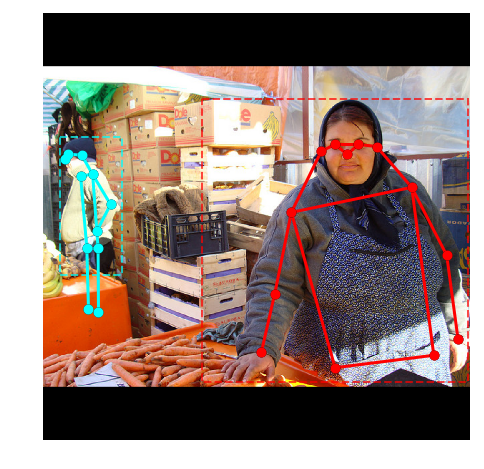

In [12]:
importlib.reload(visualize)

# Load a test image
image_id = random.choice(dataset_val.image_ids)#[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)
masks = utils.sparse_to_dense_masks(gt_kp_masks, image.shape)
    
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)

visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 17, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 17, 28, 28)
masks.shape (3, 17, 28, 28)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int64
bbox                     shape: (3, 4)                min:   19.00000  max:  810.00000  int32
masks                    shape: (3, 17, 1024, 1024)   min:    0.00000  max:    1.00000  float64


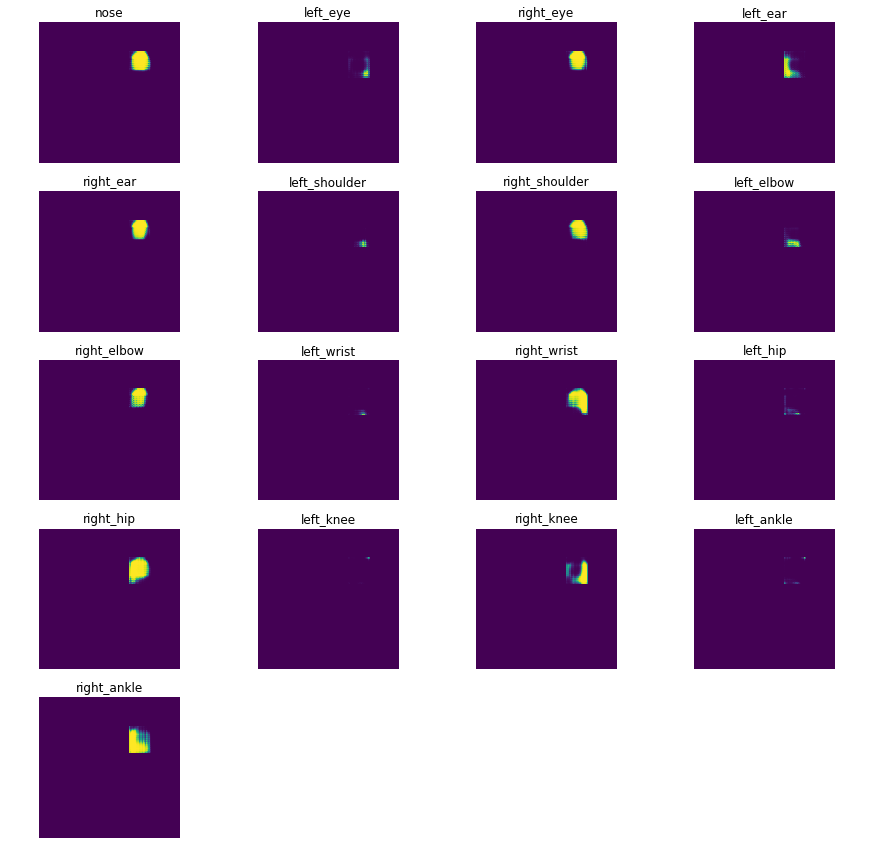

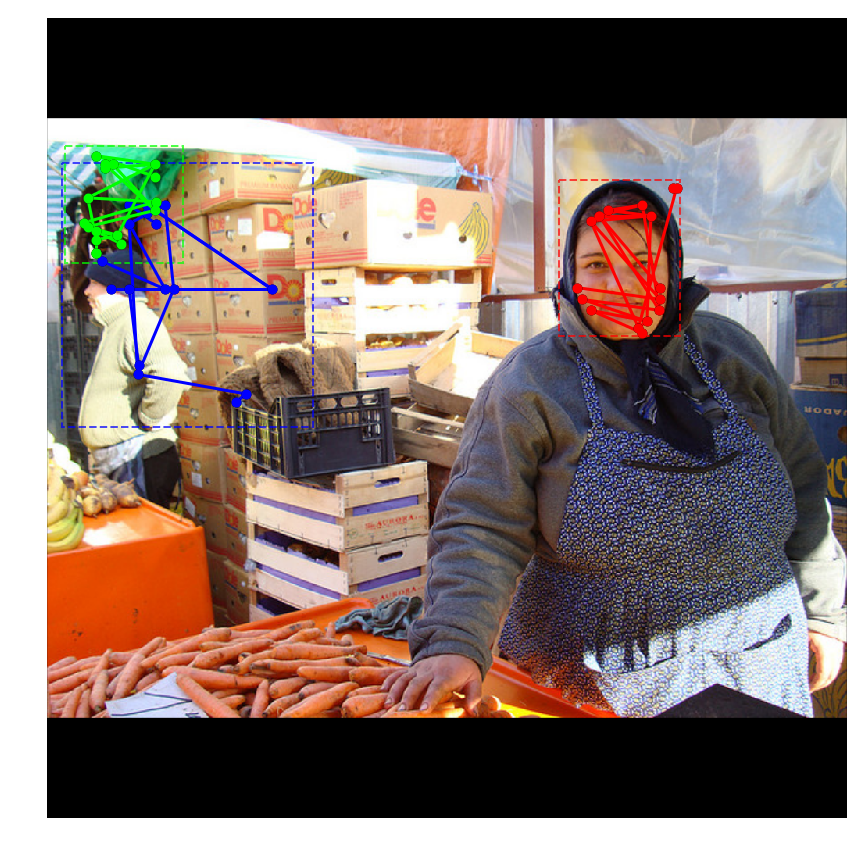

In [13]:
importlib.reload(modellib)

# Load a test image
#image_id = np.random.choice(dataset_val.image_ids)

# Get ground truth masks and bboxes
image = modellib.load_image_gt(dataset_val, inference_config, image_id)[0]

results = model.detect([image], verbose=1)
r = results[0]

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
#log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(kp_masks[0, i])


plt.show()

visualize.display_keypoints(image, bbox, kp_masks,
                            skeleton=dataset_train.skeleton,
                            figsize=(15, 15))